In [172]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import datetime
from datetime import timedelta, date
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
import plotly.express as px
import webbrowser
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
from NotifyMe import Notifier
webbrowser.register('chrome', None, webbrowser.BackgroundBrowser('C:\\Program Files (x86)\\Google\\Chrome\\Application\\chrome.exe'))

In [125]:
#Set up notification system FOR MY USE ONLY
N = Notifier()

In [7]:
symbols = ['ACB', 'F', 'GE', 'DIS', 'AAL', 'GPRO', 'DAL', 'MSFT', 'CCL', 'AAPL', 'FIT', 'SNAP', 'PLUG', 'BAC', 'BA', 'NCLH', 'INO', 'UAL', 'UBER', 'CGC', 'TSLA', 'AMD', 'CRON', 'RCL', 'TWTR', 'GRPN', 'FB', 'SBUX', 'MRO', 'ZNGA', 'BABA', 'T', 'KO', 'APHA', 'USO', 'XOM', 'AMZN', 'MFA', 'JBLU', 'NIO', 'MRNA', 'LUV', 'GM', 'GILD', 'MGM', 'SAVE', 'NFLX', 'NRZ', 'SPCE', 'LK', 'VSLR', 'AMC', 'PENN', 'VOO', 'TLRY', 'HAL', 'NOK', 'NVDA', 'CPRX', 'LYFT', 'SQ', 'SPY', 'V', 'NKE', 'SIRI', 'UCO', 'WORK', 'CPE', 'BYND', 'KOS', 'ET', 'OXY', 'PFE', 'ZM', 'CRBP', 'SPHD', 'FCEL', 'VKTX', 'JPM', 'NTDOY', 'NYMT', 'BP', 'ATVI', 'CSCO', 'WFC', 'WMT', 'GOOGL', 'INTC', 'GLUU', 'AUY', 'VTI', 'ERI', 'TXMD', 'SNE', 'PTON', 'ROKU', 'JNJ', 'IVR', 'MU']

# Feature Engineering

Here I want to create a column that looks at the variance over time, and flags days where the change was greater than the variance. I'll ultimately use that as my target.
The idea behind this is if I see a movement that is statistically unlikely for a stock, then it's noteworthy and I should buy (either the stock or perhaps an option).

In [15]:
"""Look at week long spans"""
start_date = datetime.date(2020, 4, 1)
end_date =  datetime.date(2020, 9, 14)
df = pd.DataFrame()
for i in symbols:
    tckr = yf.Ticker(i)
    results = tckr.history(start=start_date, end = end_date)
    #results.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
    results['Symbol'] =[i]* int(results.shape[0])
    results.reset_index(inplace = True)
    df = df.append(results, ignore_index=True)
    print(i, 'dataframe added to base.')
print('Complete')

ACB dataframe added to base.
F dataframe added to base.
GE dataframe added to base.
DIS dataframe added to base.
AAL dataframe added to base.
GPRO dataframe added to base.
DAL dataframe added to base.
MSFT dataframe added to base.
CCL dataframe added to base.
AAPL dataframe added to base.
FIT dataframe added to base.
SNAP dataframe added to base.
PLUG dataframe added to base.
BAC dataframe added to base.
BA dataframe added to base.
NCLH dataframe added to base.
INO dataframe added to base.
UAL dataframe added to base.
UBER dataframe added to base.
CGC dataframe added to base.
TSLA dataframe added to base.
AMD dataframe added to base.
CRON dataframe added to base.
RCL dataframe added to base.
TWTR dataframe added to base.
GRPN dataframe added to base.
FB dataframe added to base.
SBUX dataframe added to base.
MRO dataframe added to base.
ZNGA dataframe added to base.
BABA dataframe added to base.
T dataframe added to base.
KO dataframe added to base.
APHA dataframe added to base.
USO dat

In [138]:
def daily_mean(x):
    values = [x['Open'], x['High'], x['Low'], x['Close']]
    return mean(values)
def daily_stddev(x):
    values = [x['Open'], x['High'], x['Low'], x['Close']]
    return stdev(values)
def daily_pct_change(x):
    return (x['Close']-x['Open'])/x['Open']
def notable_change(x):
    return 1 if abs(x['Pct_Change']) > sym_std[x['Symbol']] else 0
def prior_trend(x, num_of_days):
    _date =x['Date']
    _start = _date - timedelta(days=num_of_days)
    temp = df[df['Symbol'] == x['Symbol']]
    temp = temp[temp['Date'] <= _date]
    temp = temp[temp['Date']> _start]
    return temp['Pct_Change'].mean()

df['Mean'] = df.apply(lambda x: daily_mean(x), axis=1)
df['Std_Dev'] = df.apply(lambda x: daily_stddev(x), axis=1)
df['Pct_Change'] = df.apply(lambda x: daily_pct_change(x), axis=1)
df['Notable_Change'] = df.apply(lambda x: notable_change(x), axis=1)
df['Three_Day_Movement'] = df.apply(lambda x: prior_trend(x, 3), axis=1)
df['Five_Day_Movement'] = df.apply(lambda x: prior_trend(x, 5), axis=1)


In [139]:
df['Shifted_Notable_Change'] = df['Notable_Change'].shift(1)

for i in symbols:
    #remove all the earliest dates to account for the shift
    temp = df[df['Symbol'] ==i]
    index = temp[temp['Date']==temp['Date'].iloc[0]].index
    df.drop(index, inplace=True)

In [174]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol,Mean,Std_Dev,Pct_Change,Notable_Change,Three_Day_Movement,Shifted_Notable_Change,Five_Day_Movement,Date_Only,Enc_Symbol
2,2020-04-03,10.40,10.44,9.48,9.72,2549000.0,0.0,0.0,ACB,10.0100,0.483735,-0.065385,0,-0.030684,0.0,-0.030684,2020-04-03,2
3,2020-04-06,10.14,10.37,9.36,9.60,4244600.0,0.0,0.0,ACB,9.8675,0.467574,-0.053254,0,-0.053254,0.0,-0.038208,2020-04-06,2
4,2020-04-07,10.08,10.21,9.53,9.60,2423000.0,0.0,0.0,ACB,9.8550,0.340245,-0.047619,0,-0.050437,0.0,-0.055419,2020-04-07,2
5,2020-04-08,9.88,10.39,9.60,10.22,2888000.0,0.0,0.0,ACB,10.0225,0.352550,0.034413,0,-0.022154,0.0,-0.022154,2020-04-08,2
6,2020-04-09,10.56,11.16,10.32,10.51,2554900.0,0.0,0.0,ACB,10.6375,0.363352,-0.004735,0,-0.005980,0.0,-0.017799,2020-04-09,2


In [137]:
sym_std = {}
for i in symbols:
    temp = df[df['Symbol'] == i]
    sym_std[i] = temp['Pct_Change'].std()*2
    print(i, temp['Pct_Change'].std()*2)

ACB 0.1333837710063991
F 0.05057897510378018
GE 0.058496602509301644
DIS 0.03725803325451775
AAL 0.10383406584471451
GPRO 0.06837737476129356
DAL 0.07195783341846386
MSFT 0.03364776659403646
CCL 0.09064376071768232
AAPL 0.03768191080614968
FIT 0.025982700079061363
SNAP 0.057841008863866526
PLUG 0.09114833330699669
BAC 0.04709913912166268
BA 0.0713465020959756
NCLH 0.11221732212610476
INO 0.1346128030405089
UAL 0.10099936314362776
UBER 0.05552411419236621
CGC 0.07473040352841086
TSLA 0.08530627585395797
AMD 0.06495016185131904
CRON 0.08084919609785923
RCL 0.09943132378811129
TWTR 0.049135553055866976
GRPN 0.12148330667911758
FB 0.04131349965412755
SBUX 0.03182018218041175
MRO 0.07953500838098984
ZNGA 0.04541737390746258
BABA 0.031767479710251956
T 0.02781269985913644
KO 0.03092977867150694
APHA 0.07491643110433216
USO 0.059910637756447366
XOM 0.0489804529813494
AMZN 0.039764093539814034
MFA 0.11280224407411951
JBLU 0.0782784085431558
NIO 0.11694766491815635
MRNA 0.09643650752906952
LUV 

In [102]:
#convert df datetime to date
df['Date_Only'] = df['Date'].dt.date

In [173]:
#Label Encode Symbols 
encoder = LabelEncoder()
df['Enc_Symbol'] = encoder.fit_transform(df['Symbol'])

# Train Test Setup

In [244]:
columns = ['Volume', 'Dividends', 'Stock Splits', 'Pct_Change', 'Three_Day_Movement', 'Five_Day_Movement']
target_col = ['Shifted_Notable_Change']
X = df[columns]
y = df[target_col]

In [245]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=.3, train_size=.7, shuffle=False, stratify = None, random_state = 0) #double check stratify

In [246]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_params = {'max_depth':[i for i in range(3,11, 2)], 
              'n_estimators':[100, 300, 500, 1000, 5000, 10000], 
              'learning_rate':[.1], 
              'n_jobs':[4],
              }
xgb = XGBClassifier()
xgb_rand_search  = GridSearchCV(xgb, xgb_params, scoring='f1', cv=5, refit=True)
xgb_rand_search.fit(train_X, train_y)
print('Best Score:', xgb_rand_search.best_score_)
print('Best Parameters:', xgb_rand_search.best_params_)
print('Train Score:', xgb_rand_search.score(train_X, train_y))
print('Valid Score:', xgb_rand_search.score(valid_X, valid_y))
N.notify('Done Searching')

Best Score: 0.21928857692015588
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 4}
Train Score: 0.45901639344262285
Valid Score: 0.1773399014778325


In [256]:
xgb_params = {'max_depth':5, 
              'n_estimators':100, 
              'learning_rate':.1, 
              'n_jobs':4,
              }
my_model = XGBClassifier(**xgb_params)
my_model.fit(X, y, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:>

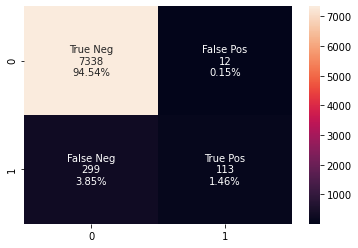

In [248]:
xgb_predictions = my_model.predict(train_X)

xgb_cf_matrix = confusion_matrix(train_y, xgb_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in xgb_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in xgb_cf_matrix.flatten()/np.sum(xgb_cf_matrix)]
labels = [f'{_1}\n{_2}\n{_3}' for _1, _2, _3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(xgb_cf_matrix, annot=labels, fmt='')

# Simulate model with the past

The goal of this section is to run the model through a few months of use with imaginary money and see how it performs

In [237]:
class MyMoney:
    """
    This class serves to manage the portfolio/money aspect of the simulation.
    """
    def __init__(self, starting_funds):
        self.funds = starting_funds
        self.portfolio = {}
        self.chunk_pct = .2
    
    def add_to_portfolio(self, symbol, amount, date_added):
        symbol = symbol[0]
        if symbol not in self.portfolio.keys():
            self.portfolio[symbol] = [amount, date_added]
            self.funds = self.funds - amount
        else:
            self.portfolio[symbol] = [self.portfolio[symbol][0]+ amount, date_added]
            self.funds = self.funds - amount

    def sell_from_portfolio(self, symbol, pct_change):
        self.funds += (self.portfolio[symbol][0] + (self.portfolio[symbol][0]*pct_change))
        self.portfolio.pop(symbol)

    def total_portfolio(self, _date):
        total_amount = self.funds
        for i in self.portfolio.keys():
            date_bought = self.portfolio[i][1]
            date_sold = _date
            temp = df[df['Symbol']==i]
            buy_price = float(temp[temp['Date_Only']==date_bought]['Open'])
            sell_price = float(temp[temp['Date_Only']==date_sold]['Open'])
            pct_change = (sell_price-buy_price)/buy_price
            total_amount+= self.portfolio[i][0]+ (self.portfolio[i][0]*pct_change)
        return total_amount
    
    def get_amount(self, _date):
        want_to_spend = .2 * self.total_portfolio(_date)
        if want_to_spend< self.funds:
            return want_to_spend
        elif self.funds < want_to_spend and self.funds != 0:
            return self.funds
        else:
            return False

In [258]:
class StockSimulator:
    def __init__(self, start_date, symbols, model):
        self._date = start_date
        self.end_date = date(2020, 9, 1)
        self.symbols = symbols
        self.money = MyMoney(1000)
        self._LOG = pd.DataFrame()
        self.model = model
    
    def collect_inputs(self):
        inputs = []
        for sym in self.symbols:
            temp = df[df['Symbol']==sym]
            temp = temp[temp['Date_Only']==self._date]
            temp = temp[['Volume', 'Dividends', 'Stock Splits', 'Pct_Change', 'Three_Day_Movement', 'Five_Day_Movement']]
            inputs.append([sym,temp])
        return inputs

    def make_predictions(self, model_inputs):
        if model_inputs[1].empty:
            return False
        prediction = self.model.predict(model_inputs[1])
        if prediction == 1 and float(model_inputs[1]['Pct_Change'])>0: 
            return True
        else:
            return False


    def transaction(self, symbol):
        amount = self.money.get_amount(self._date)
        if amount:
            print('Bought', symbol)
            self.money.add_to_portfolio(symbol, amount, self._date)

    def auto_sell(self):
        _keys = list(self.money.portfolio.keys())
        for i in _keys:
            if self.money.portfolio[i][1]+timedelta(days=2)<=self._date:
                if self._date in df['Date_Only'].unique():
                    date_bought = self.money.portfolio[i][1]
                    date_sold = self._date
                    temp = df[df['Symbol']==i]
                    buy_price = float(temp[temp['Date_Only']==date_bought]['Open'])
                    sell_price = float(temp[temp['Date_Only']==date_sold]['Open'])
                    change = (sell_price-buy_price)/buy_price
                    self.money.sell_from_portfolio(i, change)

    def RUN_SIM(self): #TODO this could use some serious cleanup for naming
        while self._date < self.end_date:
            days_inputs = self.collect_inputs()
            daily_predictions=[]
            for i in days_inputs:
                daily_predictions.append([days_inputs[0], self.make_predictions(days_inputs[1])])
            for i in daily_predictions:
                if i[1]:
                    self.transaction(i[0])
            self.auto_sell()
            self._date  = self._date + timedelta(days=1)
            if self._date in df['Date_Only'].unique():
                print(self._date, self.money.total_portfolio(self._date))



In [259]:
sim = StockSimulator(date(2020, 4, 1), symbols, my_model)
sim.RUN_SIM()

2020-04-03 1000
2020-04-06 1000
2020-04-07 1000
2020-04-08 1000
2020-04-09 1000
2020-04-13 1000
2020-04-14 1000
2020-04-15 1000
2020-04-16 1000
2020-04-17 1000
2020-04-20 1000
2020-04-21 1000
2020-04-22 1000
2020-04-23 1000
2020-04-24 1000
2020-04-27 1000
2020-04-28 1000
2020-04-29 1000
2020-04-30 1000
2020-05-01 1000
2020-05-04 1000
2020-05-05 1000
2020-05-06 1000
2020-05-07 1000
2020-05-08 1000
2020-05-11 1000
2020-05-12 1000
2020-05-13 1000
2020-05-14 1000
2020-05-15 1000
2020-05-18 1000
2020-05-19 1000
2020-05-20 1000
2020-05-21 1000
2020-05-22 1000
2020-05-26 1000
2020-05-27 1000
2020-05-28 1000
2020-05-29 1000
2020-06-01 1000
2020-06-02 1000
2020-06-03 1000
2020-06-04 1000
2020-06-05 1000
2020-06-08 1000
2020-06-09 1000
2020-06-10 1000
2020-06-11 1000
2020-06-12 1000
2020-06-15 1000
2020-06-16 1000
2020-06-17 1000
2020-06-18 1000
2020-06-19 1000
2020-06-22 1000
2020-06-23 1000
2020-06-24 1000
2020-06-25 1000
2020-06-26 1000
2020-06-29 1000
2020-06-30 1000
2020-07-01 1000
2020-07-